In [1]:
from mylib.statistic_test import *
from sklearn.decomposition import PCA
# Import isomap
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from umap.umap_ import UMAP
from mazepy.basic._time_sync import _coordinate_recording_time
from mazepy.datastruc.neuact import SpikeTrain, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin

# Gaussian smoothing
from scipy.ndimage import gaussian_filter
    
code_id = "0865 - Map Swing"
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)
dir_name0 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")

pass

        E:\Data\FinalResults\Dsp\0865 - Map Swing is already existed!


Neural Trajectory Shape: (187, 5712)


e:\Anaconda\envs\maze\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Anaconda\envs\maze\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


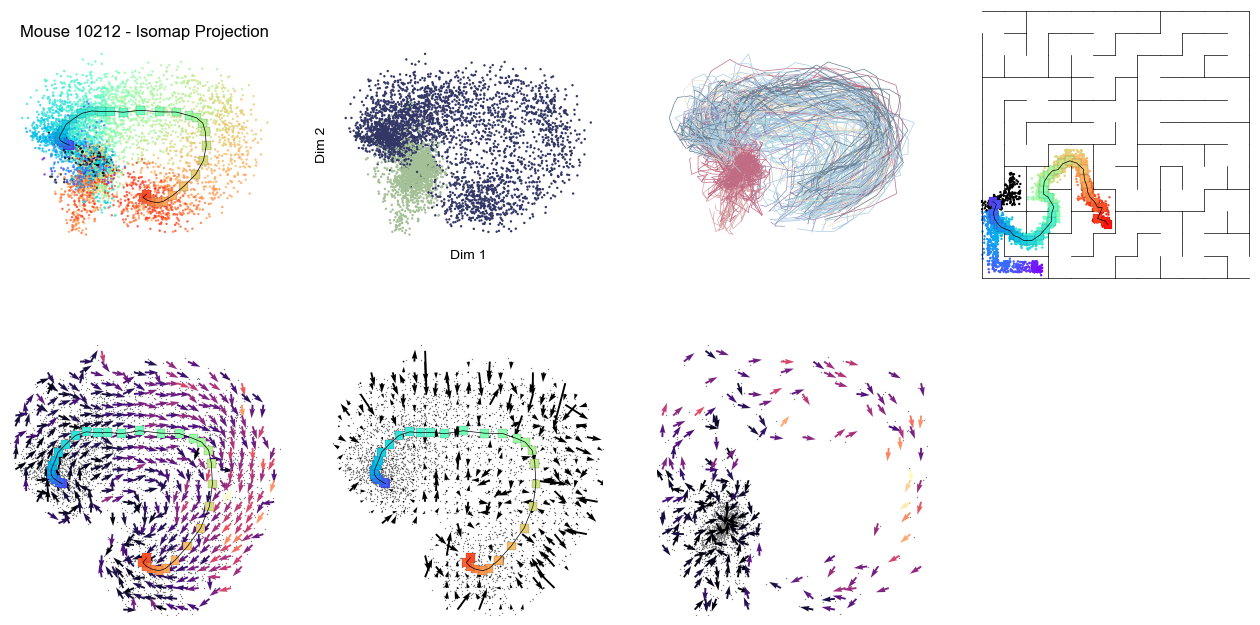

Neural Trajectory Shape: (252, 6729)


C:\Users\12454\AppData\Local\Temp\ipykernel_4668\570721086.py:125: RuntimeWarning: Mean of empty slice
  dx_mean = np.nanmean(rdx[idx])
C:\Users\12454\AppData\Local\Temp\ipykernel_4668\570721086.py:126: RuntimeWarning: Mean of empty slice
  dy_mean = np.nanmean(rdy[idx])


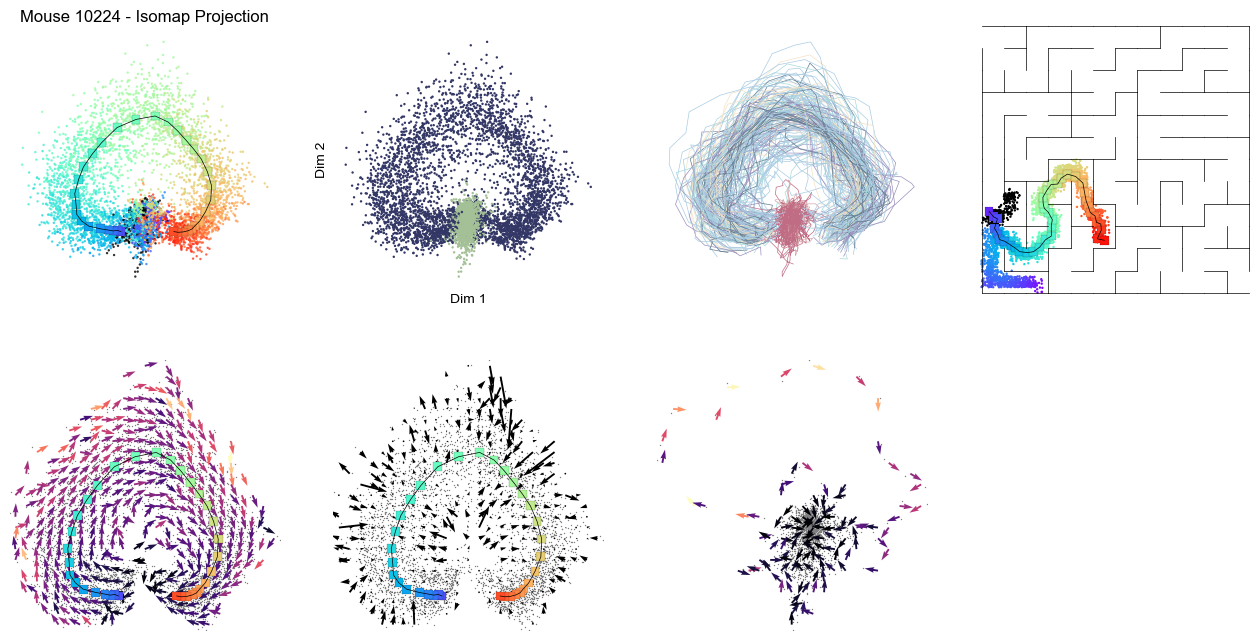

Neural Trajectory Shape: (396, 5474)


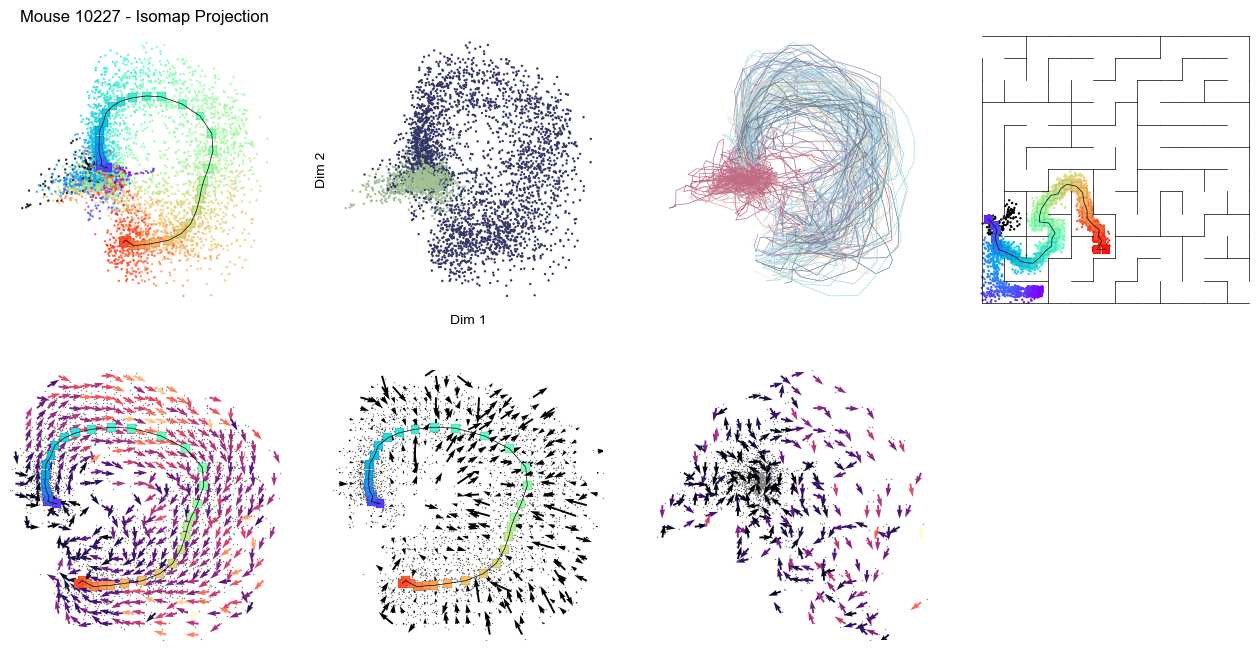

Neural Trajectory Shape: (406, 8587)


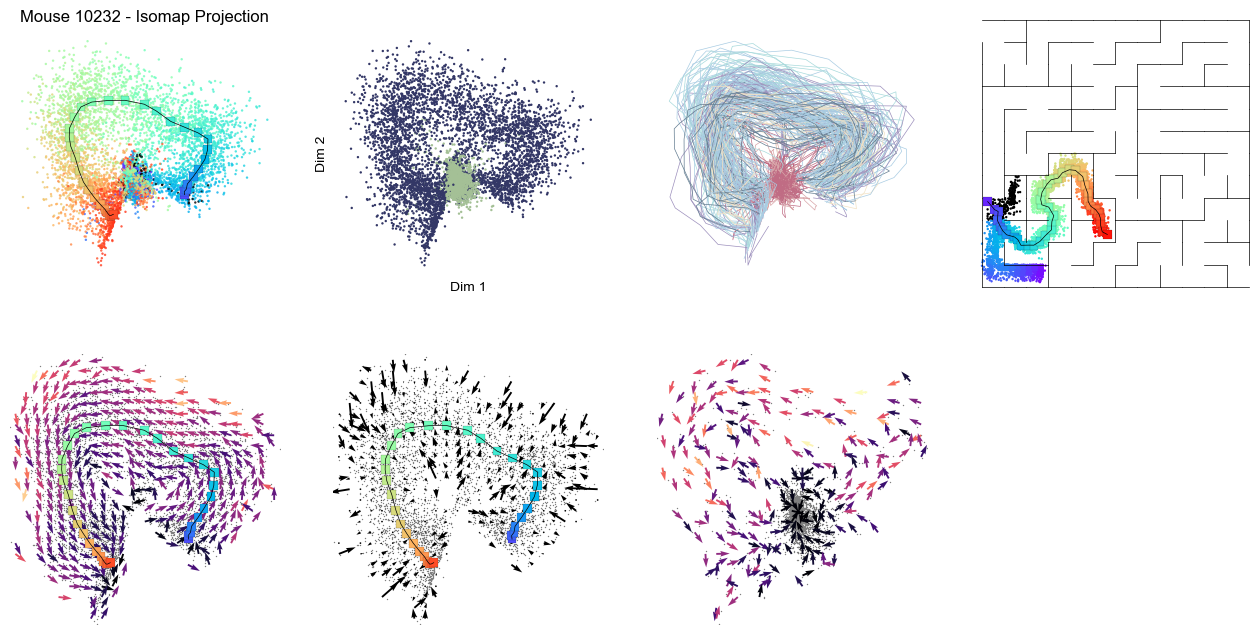

In [2]:

def fit_kmeans(X, R: int, kmeans_init=None, is_return_model: bool = False):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
    
    Returns
    -------
    U, V
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    if kmeans_init is not None:
        kmean = KMeans(n_clusters=R, init=kmeans_init)
    else:
        kmean = KMeans(n_clusters=R)
        
    kmean.fit(X_wrap)
    
    U = np.zeros((X.shape[0], R))
    for i in range(X.shape[0]):
        U[i, kmean.labels_[i]] = 1
        
    V = kmean.cluster_centers_
    
    if R == 2 and is_return_model == False:
        nclusters = np.sum(U, axis=0)
        if nclusters[0] < nclusters[1]:
            print(f"{nclusters[0]} < {nclusters[1]}")
            U = U[:, [1, 0]]
            V = V[[1, 0], :]
    
    if is_return_model:
        return U, V, kmean
    else:
        return U, V

pre_and_final_segment_bins = np.concatenate([CP_DSP[6][:20], [97, 98, 86]]) #np.concatenate([np.array([135, 134, 133, 121, 109, 110, 122, 123, 111, 112, 100]), CP_DSP[3]])

def get_phase_matrix(
    reduced_data:np.ndarray, 
    lap_traj: np.ndarray, 
    spine: np.ndarray = None,
    node_traj: np.ndarray = None,
    is_subtract_spine: bool = True,
    n_bins: int = 50,
):
    if is_subtract_spine and (spine is None or node_traj is None):
        raise ValueError("spine and node_traj must be provided if is_subtract_spine is True")
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]])
    effect_idx = np.concatenate([np.arange(beg[i], end[i]-1) for i in range(len(beg))])
    
    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
    
    nx = ny = n_bins
    
    x_norm = (reduced_data[:, 0] - x_min) / (x_max - x_min + 1e-10)
    y_norm = (reduced_data[:, 1] - y_min) / (y_max - y_min + 1e-10)
    
    x_binned = (x_norm // (1/nx)).astype(np.int64)
    y_binned = (y_norm // (1/ny)).astype(np.int64)
    
    if spine is not None:
        D = GetDMatrices(1, 48)
        # Mapping data points to spine
        dist_arr = (D[node_traj, 1537-1] // 2).astype(np.int64)
        spine_traj = spine[dist_arr, :2] 
        # Get Spine Evolving Vectors
        spine_diff = np.vstack([np.diff(spine[:, :2], axis=0), [np.nan, np.nan]])
        spine_diff_traj = spine_diff[dist_arr, :2]
        # Get the norm of spine evolving vectors
        spine_diff_norm = np.sqrt(spine_diff[:, 0]**2 + spine_diff[:, 1]**2)
        spine_diff_norm_traj = spine_diff_norm[dist_arr]
        # Get angles of spine evolving vectors
        angles_traj = np.arctan2(spine_diff_traj[:, 1], spine_diff_traj[:, 0])
            
        spine_traj[:, 0] = (spine_traj[:, 0] - x_min) / (x_max - x_min + 1e-10)
        spine_traj[:, 1] = (spine_traj[:, 1] - y_min) / (y_max - y_min + 1e-10)      
        spine[:, 0] = (spine[:, 0] - x_min) / (x_max - x_min + 1e-10)
        spine[:, 1] = (spine[:, 1] - y_min) / (y_max - y_min + 1e-10)  

        # Data points evolving vectors
        dx = np.diff(x_norm)
        dy = np.diff(y_norm)
        distance_to_spine = np.sqrt(dx**2 + dy**2)
        
        v = np.vstack([dx, dy]).T
        s = np.vstack([spine_diff_traj[:-1, 0], spine_diff_traj[:-1, 1]]).T
        d = np.vstack([x_norm - spine_traj[:, 0], y_norm - spine_traj[:, 1]])[:, :-1].T
        
        r = v - np.sum(v * s, axis=1, keepdims=True) / np.linalg.norm(s, axis=1, keepdims=True)**2 * s
        
    if is_subtract_spine:
        rdx = r[:, 0]
        rdy = r[:, 1]
        
        #inner_product = dx * spine_diff_traj[:-1, 0] + dy * spine_diff_traj[:-1, 1]
        #rdx = dx - np.cos(angles_traj[:-1]) * (inner_product / spine_diff_norm_traj[:-1])
        #rdy = dy - np.sin(angles_traj[:-1]) * (inner_product / spine_diff_norm_traj[:-1])
        radial_norm = np.sqrt(rdx**2 + rdy**2)
    else:
        rdx = np.diff(x_norm)
        rdy = np.diff(y_norm)
        
    angles_mat = np.zeros((nx, ny))
    strengths = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            idx = np.where((x_binned == i) & (y_binned == j))[0]
            idx = idx[np.isin(idx, effect_idx)]
            if len(idx) <= 0:
                angles_mat[ny-j-1, i] = np.nan
                strengths[ny-j-1, i] = np.nan
            else:
                dx_mean = np.nanmean(rdx[idx])
                dy_mean = np.nanmean(rdy[idx])
                angles_mat[ny-j-1, i] = np.arctan2(dy_mean, dx_mean)
                strengths[ny-j-1, i] = np.sqrt(dx_mean**2 + dy_mean**2)
                
    return angles_mat, strengths, x_norm, y_norm, spine

def visualize_phase_plot(
    reduced_data:np.ndarray, 
    lap_traj: np.ndarray, 
    ax: Axes, 
    spine: np.ndarray = None,
    node_traj: np.ndarray = None,
    is_subtract_spine: bool = True,
    n_bins: int = 50,
    style: int = 1
):
    if is_subtract_spine and (spine is None or node_traj is None):
        raise ValueError("spine and node_traj must be provided if is_subtract_spine is True")
    
    nx, ny = n_bins, n_bins
    angles_mat, strengths, x_norm, y_norm, spine = get_phase_matrix(
        reduced_data=reduced_data, 
        lap_traj=lap_traj, 
        spine=spine, 
        node_traj=node_traj, 
        is_subtract_spine=is_subtract_spine, 
        n_bins=n_bins
    )

    """             
    sigma = 0.1
    dx, dy = np.sin(angles_mat), np.cos(angles_mat)
    nan_angle_idx = np.isnan(angles_mat)
    dx[nan_angle_idx] = 0
    dy[nan_angle_idx] = 0
    dx = gaussian_filter(dx, sigma=sigma)
    dy = gaussian_filter(dy, sigma=sigma)
    angles_mat[nan_angle_idx] = np.arctan2(dy[nan_angle_idx], dx[nan_angle_idx])
    
    strengths[nan_angle_idx] = 0
    strengths = gaussian_filter(strengths, sigma=0.5)
    strengths[nan_angle_idx] = np.nan
    """
    
    ax.axis([0, 1, 0, 1])
    ax.set_aspect('equal')
    #ax.imshow(strengths.T, cmap='coolwarm')
    x = np.linspace(0, 1, nx+1)
    y = np.linspace(0, 1, ny+1)
    x = (x[:-1] + x[1:]) / 2
    y = (y[:-1] + y[1:]) / 2
    X, Y = np.meshgrid(x, y[::-1])
    ax.scatter(
        x_norm,
        y_norm,
        c='grey',
        s=1, 
        linewidths=0
    )
    if style == 1:
        ax.quiver(
            X.flatten(),
            Y.flatten(),
            np.cos(angles_mat.flatten()),
            np.sin(angles_mat.flatten()),
            strengths.flatten(),
            cmap=sns.color_palette('magma', as_cmap=True),
            width=0.007,
            scale=20
        )
    elif style == 2:
        ax.quiver(
            X.flatten(),
            Y.flatten(),
            np.cos(angles_mat.flatten())*strengths.flatten(),
            np.sin(angles_mat.flatten())*strengths.flatten(),
            width=0.007,
            cmap=sns.color_palette('magma', as_cmap=True),
            scale=1
        )
    
    if spine is not None:  
        spine_colors = sns.color_palette("rainbow", spine.shape[0])
        ax.plot(
            spine[:, 0],
            spine[:, 1],
            lw=0.5,
            color='k'
        )        
        ax.scatter(
            spine[:, 0],
            spine[:, 1],
            c=spine_colors, 
            marker='s',
            linewidths=0.1,
            s=40,
            edgecolors='k'
        )
    return ax
    
def get_data(mouse: int, remk: bool = False):
    mouse_date = {
        10212: np.array([4, 5, 6]),
        10224: np.array([0, 1, 2]),
        10227: np.array([2, 3, 4]),
        10232: np.array([0, 1, 2])
    }
    file_name = f" {mouse}.pkl" if remk else f"{mouse}.pkl"
    if exists(join(loc, file_name)):
        with open(join(loc, f"{mouse}.pkl"), 'rb') as f:
            neural_traj, node_traj, pos_traj, speed_traj, lap_traj, session_traj, map_traj, route_traj, time_traj, len_traj = pickle.load(f)
        print(f"Neural Trajectory Shape: {neural_traj.shape}")
    else:
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        neural_traj = []
        node_traj = []
        pos_traj = []
        speed_traj = []
        lap_traj = []
        session_traj = []
        map_traj = []
        route_traj = []
        time_traj = []
        len_traj = []
        
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :]
            
        is_cell = np.where(index_map == 0, 0, 1)
        cell_count = np.sum(is_cell[mouse_date[mouse], :], axis=0)
        cell_idx = np.where(cell_count == len(mouse_date[mouse]))[0]
        
        for session in mouse_date[mouse]:
            with open(f2['Trace File'][file_idx[session]], 'rb') as f:
                trace = pickle.load(f)
                
            with open(join(dir_name0, f"{mouse}.pkl"), "rb") as f:
                X, session_label, route_label, kmeans_init = pickle.load(f)

            kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
            U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
            U = U[session_label == session, :]
            
            beg_time, end_time = trace['lap beg time'], trace['lap end time']
            beg, end = LapSplit(trace, trace['paradigm'])
            routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)    
            
            for j in range(len(beg)):
                if routes[j] in [0, 1, 2, 4, 5]:
                    if trace['is_perfect'][j] == 0:
                        continue
                    
                spike_idx = np.where(
                    (trace['ms_time'] >= beg_time[j]) & (trace['ms_time'] <= end_time[j]) &
                    (np.isnan(trace['spike_nodes_original']) == False)
                )[0]
                init_idx = spike_idx[0]
                in_seg_idx = np.where(np.isin(spike_nodes_transform(trace['spike_nodes_original'][spike_idx], 12), pre_and_final_segment_bins))[0]
                spike_idx = spike_idx[in_seg_idx]

                spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
                Spikes = trace['Spikes_original'][:, spike_idx]
                
                spike_train = SpikeTrain(
                    activity=Spikes,
                    time=trace['ms_time'][spike_idx],
                    variable=VariableBin(spike_nodes),
                )
                neural_trajs: NeuralTrajectory = spike_train.calc_neural_trajectory(500, 100)
                spike_t = np.asarray(neural_trajs.time) / 1000
                
                x = trace['correct_pos'][beg[j]:end[j], 0]/10
                y = trace['correct_pos'][beg[j]:end[j], 1]/10
                t = trace['correct_time'][beg[j]:end[j]]/1000 - trace['correct_time'][beg[j]]/1000
                dx = np.diff(x)
                dy = np.diff(y)
                dt = np.diff(t)
                dis = np.sqrt(dx**2+dy**2)
                cumdis = np.concatenate([[0], np.cumsum(dis)])
                v = np.convolve(np.sqrt(dx**2 + dy**2), np.ones(5), mode='same') / np.convolve(dt, np.ones(5), mode='same')
                
                #spike_t = (trace['ms_time'][spike_idx] - trace['ms_time'][init_idx])/1000
                idx = _coordinate_recording_time(spike_t, t[:-1])
                
                neural_traj.append(neural_trajs.to_array()[index_map[session, cell_idx]-1, :].astype(np.float64))
                _Length = neural_traj[-1].shape[1]
                node_traj.append(neural_trajs.variable.to_array().astype(np.int64))
                pos_traj.append(np.vstack([x, y])[:, idx].astype(np.float64).T)
                speed_traj.append(v[idx].astype(np.float64))
                lap_traj.append(np.repeat(j, _Length).astype(np.int64))
                session_traj.append(np.repeat(session, _Length).astype(np.int64))
                map_traj.append(np.repeat(U[j, 1], _Length).astype(np.int64))
                route_traj.append(np.repeat(routes[j], _Length).astype(np.int64))
                time_traj.append(spike_t.astype(np.float64))
                len_traj.append(cumdis[idx].astype(np.float64))
            
        neural_traj = np.concatenate(neural_traj, axis=1)
        node_traj = np.concatenate(node_traj)
        pos_traj = np.concatenate(pos_traj, axis=0)
        speed_traj = np.concatenate(speed_traj)
        lap_traj = np.concatenate(lap_traj)
        session_traj = np.concatenate(session_traj)
        map_traj = np.concatenate(map_traj)
        route_traj = np.concatenate(route_traj)
        time_traj = np.concatenate(time_traj)
        len_traj = np.concatenate(len_traj)
        
        with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
            pickle.dump([
                neural_traj, node_traj, pos_traj, speed_traj, lap_traj, session_traj, map_traj, route_traj, time_traj, len_traj
            ], f)
        print(f"Neural Trajectory Shape: {neural_traj.shape}")
        print(join(loc, f"{mouse}.pkl"), "  is saved")
    return (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    )

def dim_red(mouse: int, neural_traj: np.ndarray, remk: bool = False):
    file_name = f" {mouse}_isomap.pkl" if remk else f"{mouse}_isomap.pkl"
    if exists(join(loc, file_name)):#exists(join(loc, f"{mouse}_umap.pkl")):#
        """ 
        with open(join(loc, f"{mouse}_umap.pkl"), 'rb') as f:
            reduced_data, umap_model = pickle.load(f)
        """
        with open(join(loc, f"{mouse}_isomap.pkl"), 'rb') as f:
            reduced_data, isomap_model = pickle.load(f)  
        
    else:
        n_component_pca = 30
        n_component_isomap = 6
        n_neighbors = 100 
        
        pca = PCA(n_components=n_component_pca)
        denoised_data = pca.fit_transform(neural_traj.T)
        """ 
        umap_model = UMAP(
            n_components=n_component_isomap, 
            n_neighbors=n_neighbors,
            metric='cosine'
        )

        print("UMAP Fitting...  ", end='')
        t1 = time.time()
        reduced_data = umap_model.fit_transform(denoised_data)
        print(f"{time.time() - t1:.3f} seconds")
        with open(join(loc, f"{mouse}_umap.pkl"), 'wb') as f:
            pickle.dump([reduced_data, umap_model], f)
        """
        t1 = time.time()
        isomap_model = Isomap(n_components=n_component_isomap, n_neighbors=n_neighbors)
        print("ISOMAP Fitting...  ", end='')
        isomap_model.fit(denoised_data)
        print(f"{time.time() - t1:.3f} seconds")
        reduced_data = np.zeros((neural_traj.shape[1], n_component_isomap))
        print("ISOMAP Transforming...")
        for i in tqdm(range(0, neural_traj.shape[1], 1000)):
            sup_idx = min(i + 1000, neural_traj.shape[1])
            reduced_data[i:sup_idx] = isomap_model.transform(denoised_data[i:sup_idx])
        
        # SVD Transform
        # U, S, VT = np.linalg.svd(reduced_data, full_matrices=False)
        # reduced_data = U[:, :n_component_isomap] * S[:n_component_isomap]
        print(f"Reduced Data Shape: {reduced_data.shape}")
        
        with open(join(loc, f"{mouse}_isomap.pkl"), 'wb') as f:
            pickle.dump([reduced_data, isomap_model], f)
    return reduced_data, isomap_model

def fit_spine(
    node_traj: np.ndarray, 
    map_traj: np.ndarray, 
    route_traj: np.ndarray,
    reduced_data:np.ndarray
):
    convert_to_spine_traj = np.zeros_like(map_traj, dtype=np.int64)-1
    D = GetDMatrices(1, 48)
    dist_range = D[1537-1, 1893-1] + 1e-8
    n_bin_m0 = int(dist_range // 2) + 1
    
    # Compute Map 1 Spine
    m0 = np.where((map_traj == 0)&(route_traj != 6)&(route_traj != 3))[0]
    dist_arr = (D[node_traj[m0], 1537-1] // 2).astype(np.int64)
    spine_m0 = np.zeros((n_bin_m0, reduced_data.shape[1])) * np.nan
    for i in range(n_bin_m0):
        idx = np.where(dist_arr == i)[0]
        if len(idx) > 0:
            spine_m0[i, :] = np.mean(reduced_data[m0[idx], :], axis=0)
            convert_to_spine_traj[m0[idx]] = i
        
    # Compute Map 2 Spine
    m1 = np.where(map_traj == 1)[0]
    dist_range = D[2268-1, 1893-1] + 1e-8 # Next son bin of 135
    n_bin_m1 = int(dist_range // 2) + 1
    dist_arr = (D[node_traj[m1], 2268-1] // 2).astype(np.int64)
    spine_m1 = np.zeros((n_bin_m1, reduced_data.shape[1])) * np.nan
    for i in range(n_bin_m1):
        idx = np.where(dist_arr == i)[0]
        if len(idx) > 0:
            spine_m1[i, :] = np.mean(reduced_data[m1[idx], :], axis=0)
            convert_to_spine_traj[m1[idx]] = i + n_bin_m0
    
    spine_m0[:, 0] = np.convolve(spine_m0[:, 0], np.ones(3)/3, mode='same')
    spine_m1[:, 0] = np.convolve(spine_m1[:, 0], np.ones(3)/3, mode='same')
    spine_m0[:, 1] = np.convolve(spine_m0[:, 1], np.ones(3)/3, mode='same')
    spine_m1[:, 1] = np.convolve(spine_m1[:, 1], np.ones(3)/3, mode='same')
    return spine_m0, spine_m1, convert_to_spine_traj

def visualize(mouse: int, remk_data: bool = False, remk_isomap: bool = False):
    (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    ) = get_data(mouse, remk=remk_data)
    
    reduced_data, isomap_model = dim_red(mouse, neural_traj, remk=remk_isomap)
    
    D = GetDMatrices(1, 48)
    
    dist_arr = D[node_traj, 2303]
    colors = sns.color_palette('rainbow', as_cmap=True)(1-(dist_arr - dist_arr.min()) / (dist_arr.max() + 1e-10 - dist_arr.min()))
    err_bin_idx = np.where(np.isin(S2F[node_traj], [97, 98, 86]))[0]
    colors[err_bin_idx, :] = np.array([0, 0, 0, 1])
    map_colors = MAPPaletteRGBA[map_traj, :]
    session_colors = [sns.color_palette('rainbow', len(np.unique(session_traj)))[i] for i in session_traj - np.min(session_traj)]

    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0], [len(lap_traj)]])
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))
    #ax0, ax1, ax2, ax3 = axes.flatten()
    ax0 = Clear_Axes(axes[0, 0])
    ax1 = Clear_Axes(axes[0, 1])
    ax2 = Clear_Axes(axes[0, 2])
    ax3 = Clear_Axes(axes[0, 3])
    ax4 = Clear_Axes(axes[1, 0])
    ax5 = Clear_Axes(axes[1, 1])
    ax6 = Clear_Axes(axes[1, 2])
    ax7 = Clear_Axes(axes[1, 3])
    x, y, z = reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2]
    #x2, y2, z2 = reduced_data[map_traj == 1, 3], reduced_data[map_traj == 1, 4], reduced_data[map_traj == 1, 5]
    
    centroid_m0, centroid_m1, convert_to_spine_traj = fit_spine(
        node_traj=node_traj,
        map_traj=map_traj,
        route_traj=route_traj,
        reduced_data=reduced_data
    )
    
    centroid_colors = sns.color_palette("rainbow", centroid_m0.shape[0])
    
    ax0.scatter(
        x, y, #z,
        c=colors, 
        s=3,
        alpha=0.8, 
        edgecolors=None,
        linewidths=0
    )
    ax0.scatter(
        centroid_m0[:, 0],
        centroid_m0[:, 1],
        #centroid_m0[:, 2],
        c=centroid_colors, 
        marker='s',
        linewidths=0.1,
        s=40,
        edgecolors='k'
    )
    ax0.plot(
        centroid_m0[:, 0],
        centroid_m0[:, 1],
        #centroid_m0[:, 2],
        lw=0.5,
        color='k'
    )
    ax1.scatter(x, y, c=map_colors, s=3, edgecolors=None,linewidths=0)    
    for i in range(len(beg)):
        ax2.plot(
                x[beg[i]:end[i]],
                y[beg[i]:end[i]],
                #z[beg[i]:end[i]],
                color=DSPPalette[route_traj[beg[i]]], 
                linewidth=0.5, 
                zorder=1
        )

    y_dim = 2# if mouse in [10227] else 3
    x_dim = 0# if mouse in [10212, 10224, 10227] else 2
    
    w = reduced_data[:, y_dim]
    x = reduced_data[:, x_dim]
 
    DrawMazeProfile(maze_type=1, axes=ax3, color='k', linewidth=0.5)
    pos_x = node_traj % 48 + np.random.rand(node_traj.shape[0]) - 0.5
    pos_y = node_traj // 48 + np.random.rand(node_traj.shape[0]) - 0.5
    ax3.scatter(
        pos_x, pos_y, color=colors, s=3, edgecolors=None, linewidths=0
    )
    behav_spine = np.zeros((centroid_m0.shape[0], 2)) * np.nan
    bins = np.concatenate([Father2SonGraph[i] for i in np.concatenate([[97], CP_DSP[6][4:20]])])
    D = GetDMatrices(1, 48)
    distances = (D[1537-1, bins-1] // 2).astype(np.int64)
    for i in range(centroid_m0.shape[0]):
        subbin = bins[np.where((distances == i))[0]]
        idx = np.where(np.isin(node_traj, subbin-1))[0]
        behav_spine[i, 0] = np.mean(pos_x[idx])
        behav_spine[i, 1] = np.mean(pos_y[idx])
    
    ax3.scatter(
        behav_spine[:, 0],
        behav_spine[:, 1],
        c=centroid_colors,
        linewidths=0.1,
        marker='s',
        s=40,
        edgecolors='k'
    )
    ax3.plot(
        behav_spine[:, 0],
        behav_spine[:, 1],
        lw=0.5,
        color='k'
    )
    ax3.set_aspect('equal')
    ax3.axis([-0.7, 47.7, 47.7, -0.7])

    ax0.set_title(f"Mouse {mouse} - Isomap Projection")
    ax1.set_ylabel("Dim 2")
    ax1.set_xlabel("Dim 1")
    
    xlim = [0, 1]
    ylim = [0, 1]

    
    ax4 = visualize_phase_plot(
        reduced_data[(map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5]))], 
        lap_traj[(map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5]))], 
        ax=ax4,
        spine=cp.deepcopy(centroid_m0),
        node_traj=node_traj[(map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5]))],
        n_bins=25,
        is_subtract_spine=False
    )
    ax4.set_xlim(*xlim)
    ax4.set_ylim(*ylim)

    ax5 = visualize_phase_plot(
        reduced_data[(map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5]))], 
        lap_traj[(map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5]))], 
        ax=ax5,
        spine=cp.deepcopy(centroid_m0),
        node_traj=node_traj[(map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5]))],
        n_bins=25,
        style=2,
    )
    ax5.set_xlim(*xlim)
    ax5.set_ylim(*ylim)
    
    ax6 = visualize_phase_plot(
        reduced_data[route_traj == 6], 
        lap_traj[route_traj == 6], 
        ax6,
        n_bins=25,
        is_subtract_spine=False
    )
    ax6.set_xlim(*xlim)
    ax6.set_ylim(*ylim)

    """
    ax7 = visualize_phase_plot(
        reduced_data, 
        lap_traj, 
        ax7, 
        is_subtract_spine=False,
        n_bins=25,
        style=1
    )
    """
    ax7.set_xlim(*xlim)
    ax7.set_ylim(*ylim)
    ax0.set_aspect('equal')
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
    ax4.set_aspect('equal')
    ax5.set_aspect('equal')
    ax6.set_aspect('equal')
    ax7.set_aspect('equal')
    plt.savefig(join(loc, f"{mouse}.png"), dpi=600)
    plt.savefig(join(loc, f"{mouse}.svg"), dpi=600)
    
    plt.show()

visualize(10212)
visualize(10224)  
visualize(10227)  
visualize(10232)

# Attractive Properties of Neuronal Manifolds

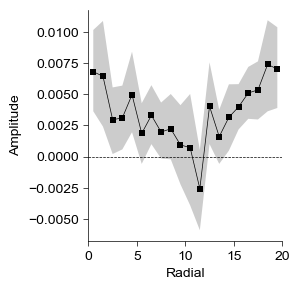

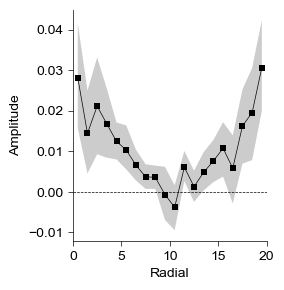

In [28]:
def process_attractors_m0(mouse: int):
    (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    ) = get_data(mouse, remk=False)
    reduced_data, isomap_model = dim_red(mouse, neural_traj, remk=False)    
    n_bins = 50
    
    idx = np.where((map_traj == 0) & (np.isin(route_traj, [0, 1, 2, 4, 5])))[0]
    spine_m0, spine_m1, convert_to_spine_traj = fit_spine(
        node_traj=node_traj[idx],
        map_traj=map_traj[idx],
        route_traj=route_traj[idx],
        reduced_data=reduced_data[idx, :2]
    )
    beg = np.concatenate([[0], np.where(np.diff(lap_traj[idx]) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj[idx]) != 0)[0], [len(lap_traj[idx])]])
    effective_idx = np.concatenate([np.arange(beg[i], end[i]) for i in range(len(beg))])
    x_max = np.max(reduced_data[idx, 0])
    x_min = np.min(reduced_data[idx, 0])
    y_max = np.max(reduced_data[idx, 1])
    y_min = np.min(reduced_data[idx, 1])
        
    x_norm = (reduced_data[idx, 0] - x_min) / (x_max - x_min + 1e-10)
    y_norm = (reduced_data[idx, 1] - y_min) / (y_max - y_min + 1e-10)
    spine = np.vstack([
        (spine_m0[:, 0] - x_min) / (x_max - x_min + 1e-10),
        (spine_m0[:, 1] - y_min) / (y_max - y_min + 1e-10)
    ]).T
        
    D = GetDMatrices(1, 48)
    dist_arr = (D[node_traj[idx], 1537-1] // 2).astype(np.int64)
    s = np.vstack([np.diff(spine, axis=0), np.array([np.nan, np.nan])])
    s_angles = np.arctan2(s[:, 1], s[:, 0])
    s_radial_angles = s_angles + np.pi/2
    if s_radial_angles[-1] > np.pi:
        s_radial_angles[-1] -= 2 * np.pi
    elif s_radial_angles[-1] < -np.pi:
        s_radial_angles[-1] += 2 * np.pi
    d = np.vstack([
        x_norm - spine[dist_arr, 0],
        y_norm - spine[dist_arr, 1]
    ]).T
    d_norm = np.sqrt(d[:, 0]**2 + d[:, 1]**2)
        
    dx = np.diff(x_norm)
    dy = np.diff(y_norm)
    v = np.vstack([dx, dy]).T
    r = v - np.sum(v * s[dist_arr[:-1]], axis=1, keepdims=True) / np.sum(s[dist_arr[:-1]]**2, axis=1, keepdims=True) * s[dist_arr[:-1]]
    r_norm = np.sqrt(r[:, 0]**2 + r[:, 1]**2)
    r_angles = np.arctan2(r[:, 1], r[:, 0])
        
    _range = np.tile(np.arange(20), (s.shape[0]-1, 1))
    strengths = np.zeros((s.shape[0]-1, 20))*np.nan
    for i in range(s.shape[0]-1):
        sub_idx = np.where((dist_arr == i)&(np.isnan(d_norm) == False))[0]
        sub_idx = sub_idx[np.isin(sub_idx, effective_idx)]
        sub_idx = sub_idx[:-1]
        if len(sub_idx) <= 0:
            continue
            
        d_angles = np.arctan2(d[sub_idx, 1], d[sub_idx, 0])
        res_direction = d_angles - s_angles[i]
        res_direction[res_direction < -np.pi] += 2 * np.pi
        res_direction[res_direction > np.pi] -= 2 * np.pi
        is_left = res_direction < 0
        d_norm_sub = d_norm[sub_idx]
        d_norm_sub[is_left] = -d_norm_sub[is_left]
        lef_bound, rig_bound = np.nanpercentile(d_norm_sub, [2.5, 97.5])
        bin_boundaries = np.concatenate([
            np.linspace(lef_bound-1e-10, 0, 11), 
            np.linspace(0, rig_bound+1e-10, 11)[1:]
        ])
        if lef_bound > 0 or rig_bound < 0:
            continue
        sub_idx = sub_idx[np.where((d_norm_sub > lef_bound) & (d_norm_sub < rig_bound))[0]]
        d_norm_sub = d_norm_sub[np.where((d_norm_sub > lef_bound) & (d_norm_sub < rig_bound))[0]]
        d_norm_binned = np.digitize(d_norm_sub, bin_boundaries) - 1
        for j in range(20):
            bidx = np.where(d_norm_binned == j)[0]
            if len(bidx) <= 0:
                continue
                
            inner_product = r[sub_idx[bidx]] * np.array([[np.cos(s_radial_angles[i]), np.sin(s_radial_angles[i])]]) # Project r onto s
            strengths[i, j] = np.nanmean(inner_product[:, 0])  # Take the mean of the inner product
    
    strengths[:, 10:] = -strengths[:, 10:]
    #strengths = -np.nancumsum(strengths, axis=1)
    #strengths -= np.mean(strengths[:, 9:11], axis=1, keepdims=True)  # Normalize the strengths
    spine_id = np.arange(spine.shape[0]-1)
    bins_id = np.arange(20)
    radial_bins_id, spine_id = np.meshgrid(bins_id, spine_id)

    return radial_bins_id.flatten(), spine_id.flatten(), strengths.flatten()

if exists(join(figdata, f'{code_id} [AttractorsM1].pkl')) == False:
    AttractorM1 = {
        'MiceID': [],
        'Spines': [],
        'Radial': [],
        'Amplitude': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        radial_bin_id, spine_id, strengths = process_attractors_m0(mouse)
        
        AttractorM1['MiceID'].append(np.repeat(mouse, strengths.shape[0]))
        AttractorM1['Spines'].append(spine_id)
        AttractorM1['Radial'].append(radial_bin_id)
        AttractorM1['Amplitude'].append(strengths)
        
    for key in AttractorM1.keys():
        AttractorM1[key] = np.concatenate(AttractorM1[key])
        
    with open(join(figdata, f'{code_id} [AttractorsM1].pkl'), 'wb') as f:
        pickle.dump(AttractorM1, f)
        
    AttractorM1D = pd.DataFrame(AttractorM1)
    AttractorM1D.to_excel(join(figdata, f'{code_id} [AttractorsM1].xlsx'), index=False)
    print(len(AttractorM1D))
else:
    with open(join(figdata, f'{code_id} [AttractorsM1].pkl'), 'rb') as f:
        AttractorM1 = pickle.load(f)
        
fig = plt.figure(figsize=(2.5, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)

sns.lineplot(
    x='Radial',
    y='Amplitude',
    data=AttractorM1,
    ax=ax,
    linewidth=0.5,
    color='k',
    err_kws={'edgecolor': None},
    marker='s',
    markersize=5,
    markeredgewidth=0,
)
ax.set_xlim(-0.5, 19.5)
ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax.set_xticks(np.linspace(-0.5, 19.5, 5), np.linspace(0, 20, 5).astype(np.int64))
plt.savefig(join(loc, 'Attractive Property [M1].png'), dpi=600)
plt.savefig(join(loc, 'Attractive Property [M1].svg'), dpi=600)
plt.show()

def process_attractors_m1(mouse: int):
    (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    ) = get_data(mouse, remk=False)
    reduced_data, isomap_model = dim_red(mouse, neural_traj, remk=False)    
    n_bins = 50
    
    idx = np.where((map_traj == 1))[0]
    beg = np.concatenate([[0], np.where(np.diff(lap_traj[idx]) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj[idx]) != 0)[0], [len(lap_traj[idx])]])
    effective_idx = np.concatenate([np.arange(beg[i], end[i]) for i in range(len(beg))])
    x_max = np.max(reduced_data[idx, 0])
    x_min = np.min(reduced_data[idx, 0])
    y_max = np.max(reduced_data[idx, 1])
    y_min = np.min(reduced_data[idx, 1])
        
    x_norm = (reduced_data[idx, 0] - x_min) / (x_max - x_min + 1e-10)
    y_norm = (reduced_data[idx, 1] - y_min) / (y_max - y_min + 1e-10)
    manifold_center = (np.mean(reduced_data[idx, :2], axis=0) - np.array([x_min, y_min])) / (np.array([x_max, y_max]) - np.array([x_min, y_min]) + 1e-10)
     
        
    D = GetDMatrices(1, 48)

    d = np.vstack([
        x_norm - manifold_center[0],
        y_norm - manifold_center[1]
    ]).T
    d_norm = np.sqrt(d[:, 0]**2 + d[:, 1]**2)
    d_angles = np.arctan2(d[:, 1], d[:, 0])
        
    dx = np.diff(x_norm)
    dy = np.diff(y_norm)
    v = np.vstack([dx, dy]).T
        
    _range = np.tile(np.linspace(0, np.pi, 19), [20, 1])
    strengths = np.zeros((20, _range.shape[1]-1))*np.nan
    for i in range(_range.shape[1]-1):
        a_lef, a_rig = _range[0, i] - np.pi, _range[0, i+1] - np.pi
        sub_idx = np.where((d_angles >= a_lef)&(d_angles < a_rig)&(np.isnan(d_norm) == False))[0]
        sub_idx = sub_idx[np.isin(sub_idx, effective_idx)]
        sub_idx = sub_idx[:-1]
        if len(sub_idx) <= 0:
            continue

        d_norm_sub = d_norm[sub_idx]
        rig_bound = np.nanpercentile(d_norm_sub, 95)
        bin_boundaries = np.linspace(0, rig_bound+1e-10, 11)
        sub_idx = sub_idx[np.where(d_norm_sub < rig_bound)[0]]
        d_norm_sub = d_norm_sub[np.where(d_norm_sub < rig_bound)[0]]
        d_norm_binned = np.digitize(d_norm_sub, bin_boundaries) - 1
        for j in range(10):
            bidx = np.where(d_norm_binned == j)[0]
            if len(bidx) <= 0:
                continue

            inner_product = -np.sum(d[sub_idx[bidx]] * v[sub_idx[bidx]], axis=1) / d_norm[sub_idx[bidx]]  # Project d onto v
            strengths[j+10, i] = np.nanmean(inner_product)  # Take the mean of the inner product
            
    for i in range(_range.shape[1]-1):
        a_lef, a_rig = _range[0, i], _range[0, i+1]
        sub_idx = np.where((d_angles >= a_lef)&(d_angles < a_rig)&(np.isnan(d_norm) == False))[0]
        sub_idx = sub_idx[np.isin(sub_idx, effective_idx)]
        sub_idx = sub_idx[:-1]
        if len(sub_idx) <= 0:
            continue
            
        d_angles_sub = d_angles[sub_idx]

        d_norm_sub = d_norm[sub_idx]
        rig_bound = np.nanpercentile(d_norm_sub, 95)
        bin_boundaries = np.linspace(0, rig_bound+1e-10, 11)
        sub_idx = sub_idx[np.where(d_norm_sub < rig_bound)[0]]
        d_norm_sub = d_norm_sub[np.where(d_norm_sub < rig_bound)[0]]
        d_norm_binned = np.digitize(d_norm_sub, bin_boundaries) - 1
        for j in range(10):
            bidx = np.where(d_norm_binned == j)[0]
            if len(bidx) <= 0:
                continue

            inner_product = -np.sum(d[sub_idx[bidx]] * v[sub_idx[bidx]], axis=1) / d_norm[sub_idx[bidx]]  # Project d onto v
            strengths[9-j, i] = np.nanmean(inner_product)  # Take the mean of the inner product

    #strengths[:10, :] = -strengths[:10, :]  # Invert the strengths for the first 10 bins
    #strengths = -np.nancumsum(strengths, axis=0)
    bins_id = np.arange(20)
    angle_id = np.linspace(0, np.pi, 19)[:-1]
    angle_id, radial_bins_id = np.meshgrid(angle_id, bins_id)

    return radial_bins_id.flatten(), angle_id.flatten(), strengths.flatten()

if exists(join(figdata, f'{code_id} [AttractorsM2].pkl')) == False:
    AttractorM2 = {
        'MiceID': [],
        'Spines': [],
        'Radial': [],
        'Amplitude': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        radial_bin_id, spine_id, strengths = process_attractors_m1(mouse)
        
        AttractorM2['MiceID'].append(np.repeat(mouse, strengths.shape[0]))
        AttractorM2['Spines'].append(spine_id)
        AttractorM2['Radial'].append(radial_bin_id)
        AttractorM2['Amplitude'].append(strengths)
        
    for key in AttractorM2.keys():
        AttractorM2[key] = np.concatenate(AttractorM2[key])
        
    with open(join(figdata, f'{code_id} [AttractorsM2].pkl'), 'wb') as f:
        pickle.dump(AttractorM2, f)
        
    AttractorM2D = pd.DataFrame(AttractorM2)
    AttractorM2D.to_excel(join(figdata, f'{code_id} [AttractorsM2].xlsx'), index=False)
    print(len(AttractorM2D))
else:
    with open(join(figdata, f'{code_id} [AttractorsM2].pkl'), 'rb') as f:
        AttractorM2 = pickle.load(f)
        
fig = plt.figure(figsize=(2.5, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Radial',
    y='Amplitude',
    data=AttractorM2,
    ax=ax,
    linewidth=0.5,
    color='k',
    err_kws={'edgecolor': None},
    marker='s',
    markersize=5,
    markeredgewidth=0,
)
ax.set_xlim(-0.5, 19.5)
ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax.set_xticks(np.linspace(-0.5, 19.5, 5), np.linspace(0, 20, 5).astype(np.int64))
plt.savefig(join(loc, 'Attractive Property [M2].png'), dpi=600)
plt.savefig(join(loc, 'Attractive Property [M2].svg'), dpi=600)
plt.show()

# Test Cross-Session Spines

Neural Trajectory Shape: (187, 5712)
Neural Trajectory Shape: (187, 5712)
Neural Trajectory Shape: (187, 5712)
(280, 2) (280,) (280,)


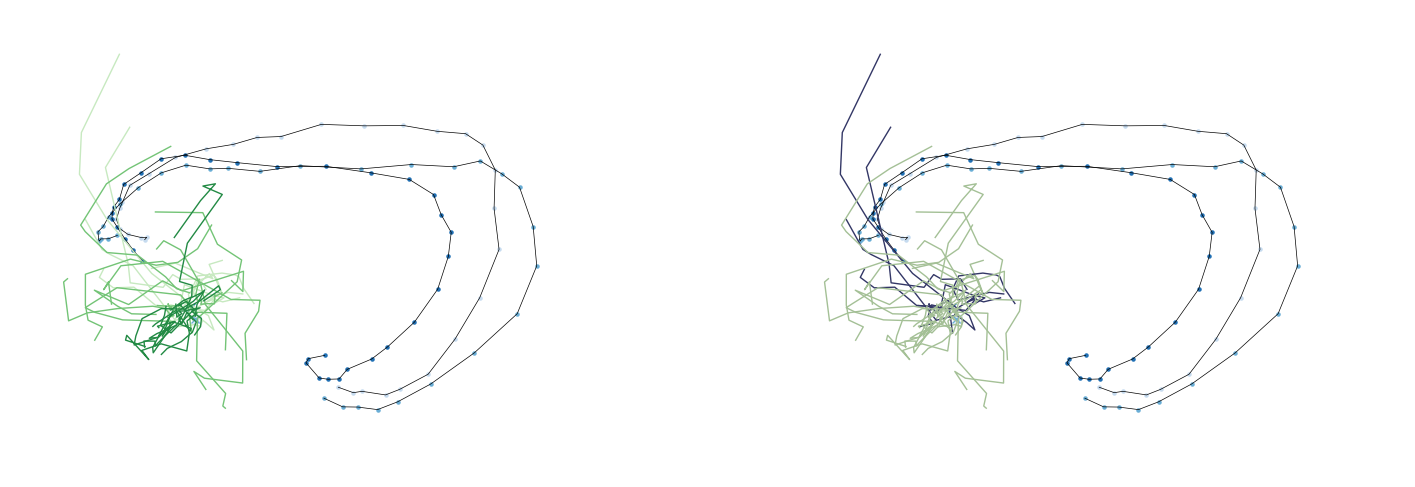

Neural Trajectory Shape: (252, 6729)
Neural Trajectory Shape: (252, 6729)
Neural Trajectory Shape: (252, 6729)
(270, 2) (270,) (270,)


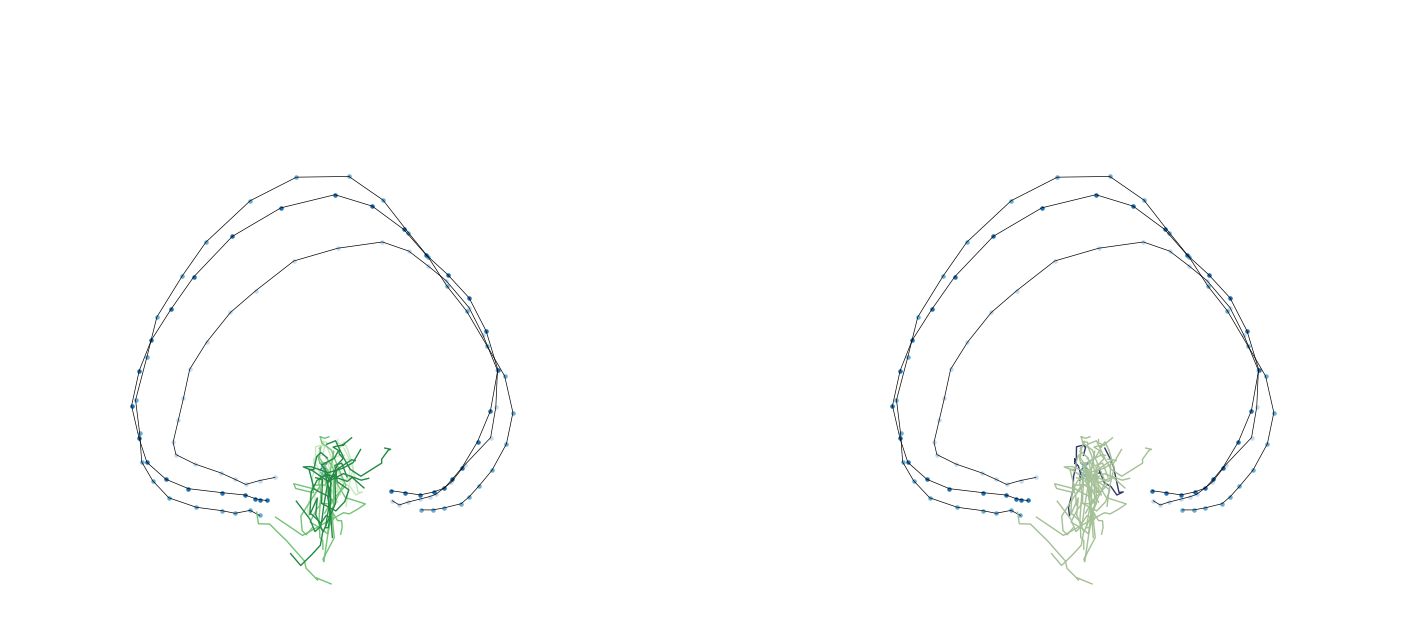

Neural Trajectory Shape: (396, 5474)
Neural Trajectory Shape: (396, 5474)
Neural Trajectory Shape: (396, 5474)
(280, 2) (280,) (280,)


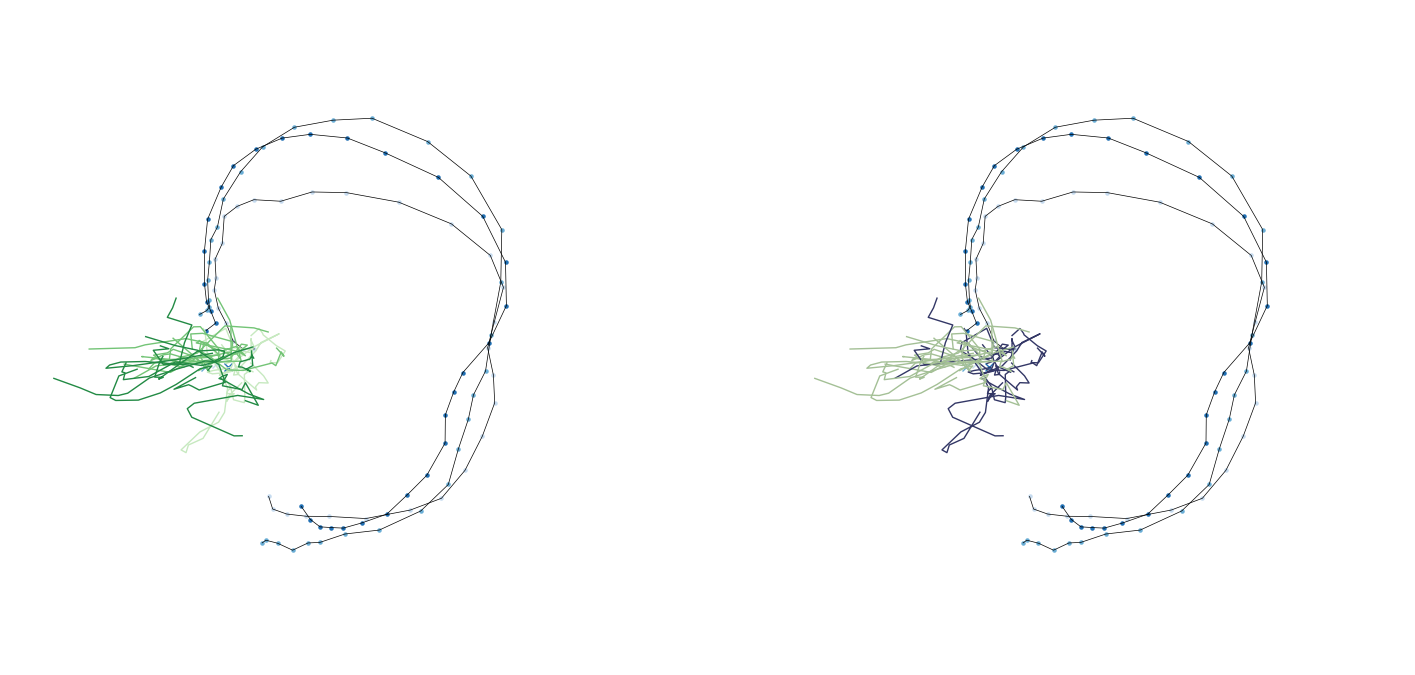

Neural Trajectory Shape: (406, 8587)
Neural Trajectory Shape: (406, 8587)
Neural Trajectory Shape: (406, 8587)
(300, 2) (300,) (300,)


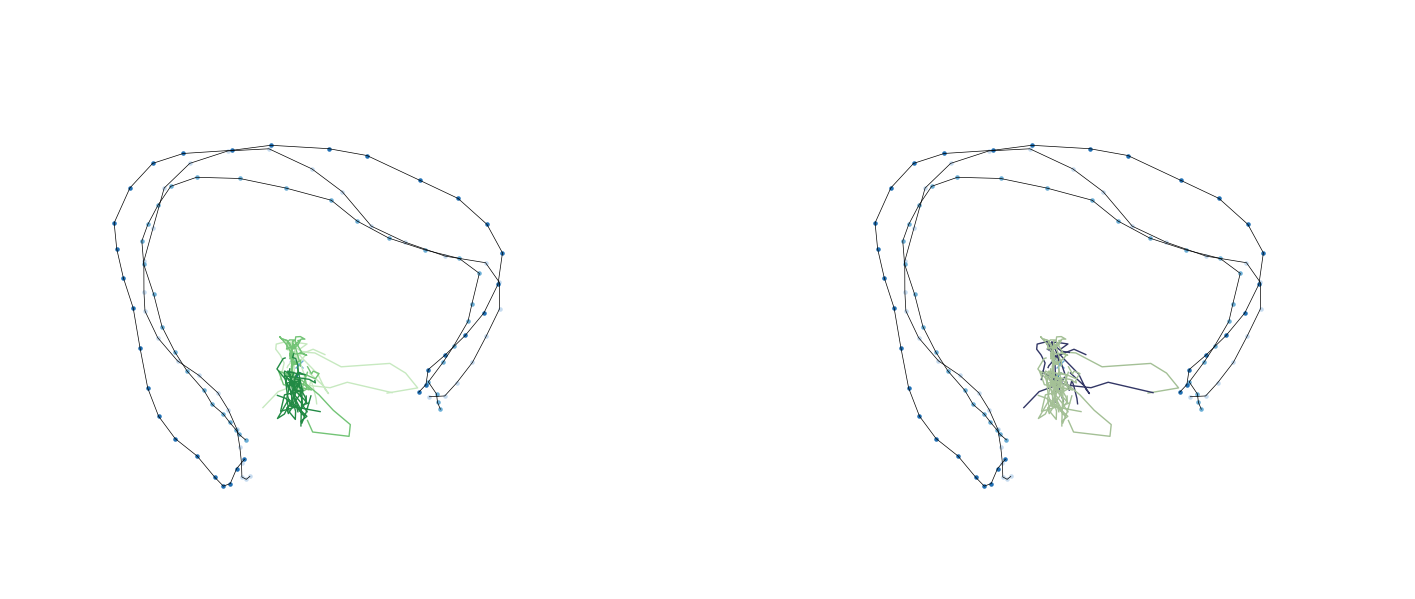

In [54]:
def get_cross_day_spine(mouse: int):
    (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    ) = get_data(mouse, remk=False)
    reduced_data, isomap_model = dim_red(mouse, neural_traj, remk=False)

    uniq_session = np.unique(session_traj)
    
    spines_m0_all = []
    center_m1_all = []
    for session in uniq_session:
        idx_m0 = np.where(
            (map_traj == 0) & 
            (np.isin(route_traj, [0, 1, 2, 4, 5])) &
            (session_traj == session)
        )[0]
        spine_m0, spine_m1, convert_to_spine_traj = fit_spine(
            node_traj=node_traj[idx_m0],
            map_traj=map_traj[idx_m0],
            route_traj=route_traj[idx_m0],
            reduced_data=reduced_data[idx_m0, :2]
        )
        
        spines_m0_all.append(spine_m0)
        
        idx_m1 = np.where(
            (map_traj == 1) & 
            (session_traj == session)
        )[0]
        
        center_m1 = np.mean(reduced_data[idx_m1, :2], axis=0)
        center_m1_all.append(center_m1)
        
    return spines_m0_all, center_m1_all

def get_starting_points(mouse: int):
    (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    ) = get_data(mouse, remk=False)
    
    reduced_data, isomap_model = dim_red(mouse, neural_traj, remk=False)
    starting_points = []
    starting_points_session = []
    starting_points_map = []
    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    
    min_session = int(np.min(session_traj))
    
    for i in range(len(beg)):
        if route_traj[beg[i]] != 6:
            continue
        
        starting_points.append(reduced_data[beg[i]:beg[i]+10, :2])
        starting_points_session.append(session_traj[beg[i]:beg[i]+10] - min_session)
        starting_points_map.append(map_traj[beg[i]:beg[i]+10])
    
    return (
        np.concatenate(starting_points, dtype=np.float64, axis=0),
        np.concatenate(starting_points_session, dtype=np.int64),
        np.concatenate(starting_points_map, dtype=np.int64)        
    )

def visualize_cross_day_spine(mouse: int):
    (
        neural_traj, 
        node_traj, 
        pos_traj, 
        speed_traj, 
        lap_traj, 
        session_traj, 
        map_traj, 
        route_traj, 
        time_traj, 
        len_traj
    ) = get_data(mouse, remk=False)
    reduced_data, isomap_model = dim_red(mouse, neural_traj, remk=False)
    
    spines_m0_all, center_m1_all = get_cross_day_spine(mouse)
    starting_points, starting_points_session, starting_points_map = get_starting_points(mouse)
    print(starting_points.shape, starting_points_session.shape, starting_points_map.shape)
    session_colors = sns.color_palette('Blues', len(spines_m0_all))
    sp_colors = sns.color_palette('Greens', len(spines_m0_all))
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))
    for m in range(2):
        ax = Clear_Axes(axes[m])
        
        for i in range(len(spines_m0_all)):
            spine_m0 = spines_m0_all[i]
            center_m1 = center_m1_all[i]
            
            ax.plot(
                spine_m0[:, 0], 
                spine_m0[:, 1], 
                lw=0.5, 
                color='k'
            )
            ax.scatter(
                spine_m0[:, 0], 
                spine_m0[:, 1], 
                s=5, 
                color=session_colors[i],
                label=f'Session {i+1}'
            )
            ax.plot(
                [center_m1[0]], 
                [center_m1[1]], 
                color=session_colors[i],
                marker='x'
            )
        if m == 0:
            c = [sp_colors[s] for s in starting_points_session]
        else:
            c = MAPPaletteRGBA[starting_points_map, :]
        
        for i in range(0, starting_points.shape[0], 10):
            ax.plot(
                starting_points[i:i+10, 0], 
                starting_points[i:i+10, 1], 
                linewidth=1,
                color=c[i]
            )

        x_min = np.min(reduced_data[:, 0])
        x_max = np.max(reduced_data[:, 0])
        y_min = np.min(reduced_data[:, 1])
        y_max = np.max(reduced_data[:, 1])
        ax.set_xlim(x_min - 0.1, x_max + 0.1)
        ax.set_ylim(y_min - 0.1, y_max + 0.1)
        ax.set_aspect('equal')
    
    #plt.savefig(join(loc, f"Cross_Day_Spine_{mouse}.png"), dpi=600)
    plt.show()

visualize_cross_day_spine(10212)
visualize_cross_day_spine(10224)
visualize_cross_day_spine(10227)
visualize_cross_day_spine(10232)

# Population Vector Correlation over Pre-Final Segment

In [2]:
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

def get_pvc(mouse: int, session: int):
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as handle:
        trace = pickle.load(handle)

    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    
    bins = CP_DSP[6]-1
    smoothed_map = smoothed_map[:, bins, :]

    with open(join(dir_name0, f"{mouse}.pkl"), 'rb') as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    U = U[session_label == session, :]
    
    averaged_map0 = np.reshape(V[0, :], [bins.shape[0], -1])
    averaged_map3 = np.reshape(V[1, :], [bins.shape[0], -1])
    averaged_map6 = trace[f'node 6']['old_map_clear'][:, bins].T
    
    pvc_corr1 = np.zeros((routes.shape[0], bins.shape[0]))
    pvc_corr4 = np.zeros((routes.shape[0], bins.shape[0]))
    
    for i in range(routes.shape[0]):
        for j in range(bins.shape[0]):
            pvc_corr1[i, j] = np.corrcoef(
                X[i, j, :], averaged_map0[j, :]
            )[0, 1]
            
            pvc_corr4[i, j] = np.corrcoef(
                X[i, j, :], averaged_map3[j, :]
            )[0, 1]
            
    
    bin_id, route_id = np.meshgrid(np.arange(bins.shape[0]), routes)
    bin_id, lap_id = np.meshgrid(np.arange(bins.shape[0]), np.arange(routes.shape[0]))
    return pvc_corr1, route_id, bin_id, lap_id, pvc_corr4

if exists(join(figdata, f"{code_id} [PVC].pkl")) == False:
    PVCData = {
        'MiceID': [],
        'Session': [],
        'Route': [],
        'Lap': [],
        'Bin': [],
        'PVC': [],
        'PVC2': [] # With Route 4
    }
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for s in tqdm(range(7)):
            if mouse in [10212, 10227] and s == 1:
                continue
            
            pvc_corr, route_id, bin_id, lap_id, pvc_corr4 = get_pvc(mouse, s)
            for i in range(pvc_corr.shape[0]):
                idx = np.where(np.isnan(pvc_corr[i, :]) == False)[0]
                pvc_corr[i, idx] = np.convolve(pvc_corr[i, idx], np.ones(3)/3, mode='same')
                idx = np.where(np.isnan(pvc_corr4[i, :]) == False)[0]
                if idx.shape[0] == 0:
                    pvc_corr4[i, :] = np.nan
                else:
                    pvc_corr4[i, idx] = np.convolve(pvc_corr4[i, idx], np.ones(3)/3, mode='same')
                
            PVCData['MiceID'].append(np.repeat(mouse, pvc_corr.shape[0] * pvc_corr.shape[1]))
            PVCData['Session'].append(np.repeat(session_convertor[mouse][s], pvc_corr.shape[0] * pvc_corr.shape[1]))
            PVCData['Route'].append(route_id.flatten())
            PVCData['Lap'].append(lap_id.flatten())
            PVCData['Bin'].append(bin_id.flatten())
            PVCData['PVC'].append(pvc_corr.flatten())
            PVCData['PVC2'].append(pvc_corr4.flatten())
    
    for k in PVCData.keys():
        PVCData[k] = np.concatenate(PVCData[k])
        
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'wb') as f:
        pickle.dump(PVCData, f)
    
    PVCD = pd.DataFrame(PVCData)
    PVCD.to_excel(join(figdata, f"{code_id} [PVC].xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id} [PVC].pkl"), 'rb') as f:
        PVCData = pickle.load(f)

mice_color = {
    10212: 'k',
    10224: MicePaletteDSP[1],
    10227: MicePaletteDSP[2],
    10232: MicePaletteDSP[3]
}
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(4*4, 3*3))
for s in range(-5, 7):
    c, r = (s+5) % 3, (s+5) // 3
    SubData = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 6))[0])
    SubData4 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 3))[0])
    SubData0 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(np.isin(PVCData['Route'], [0, 1, 2, 4, 5]))&(PVCData['Bin'] >= 4))[0])
    
    ax = Clear_Axes(axes[c, r], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.plot([0, 4.5], [0.75, 0.75], color=DSPPalette[6], linewidth=5)
    ax.plot([4.5, 11.5], [0.75, 0.75], color='#BDC8DE', linewidth=5)
    ax.plot([11.5, CP_DSP[6].shape[0]-1], [0.75, 0.75], color=DSPPalette[3], linewidth=5)
    beg = np.concatenate([[0], np.where(np.diff(SubData['Bin']) < 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(SubData['Bin']) < 0)[0] + 1, [len(SubData['Bin'])]])
    for i in range(len(beg)):
        idx = np.where((np.isnan(SubData['PVC'][beg[i]:end[i]]) == False))[0]
        ax.plot(
            SubData['Bin'][beg[i]:end[i]][idx],
            SubData['PVC'][beg[i]:end[i]][idx],
            color= mice_color[SubData['MiceID'][beg[i]]],
            linewidth=0.5
        )
    ax.set_title(f"Session {s}")
    ax.set_ylim(-0.1, 0.8)
    ax.set_yticks(np.linspace(0, 0.8, 5))
    ax.set_xlim(0, CP_DSP[6].shape[0]-1)

plt.savefig(join(loc, "PVC with Route 1.png"), dpi=600)
plt.savefig(join(loc, "PVC with Route 1.svg"), dpi=600)
plt.close()

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(4*4, 3*3))
for s in range(-5, 7):
    c, r = (s+5) % 3, (s+5) // 3
    SubData = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 6))[0])
    SubData4 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(PVCData['Route'] == 3))[0])
    SubData0 = SubDict(PVCData, PVCData.keys(), np.where((PVCData['Session'] == s)&(np.isin(PVCData['Route'], [0, 1, 2, 4, 5]))&(PVCData['Bin'] >= 4))[0])
    
    ax = Clear_Axes(axes[c, r], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.plot([0, 4.5], [0.75, 0.75], color=DSPPalette[6], linewidth=5)
    ax.plot([4.5, 11.5], [0.75, 0.75], color='#BDC8DE', linewidth=5)
    ax.plot([11.5, CP_DSP[6].shape[0]-1], [0.75, 0.75], color=DSPPalette[3], linewidth=5)
    beg = np.concatenate([[0], np.where(np.diff(SubData['Bin']) < 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(SubData['Bin']) < 0)[0] + 1, [len(SubData['Bin'])]])
    for i in range(len(beg)):
        idx = np.where((np.isnan(SubData['PVC2'][beg[i]:end[i]]) == False))[0]
        ax.plot(
            SubData['Bin'][beg[i]:end[i]][idx],
            SubData['PVC2'][beg[i]:end[i]][idx],
            color= mice_color[SubData['MiceID'][beg[i]]],
            linewidth=0.5
        )
    ax.set_title(f"Session {s}")
    ax.set_ylim(-0.1, 0.8)
    ax.set_yticks(np.linspace(0, 0.8, 5))
    ax.set_xlim(0, CP_DSP[6].shape[0]-1)

plt.savefig(join(loc, "PVC with Route 4.png"), dpi=600)
plt.savefig(join(loc, "PVC with Route 4.svg"), dpi=600)
plt.close()

# Correlation on Pre-Final Segment

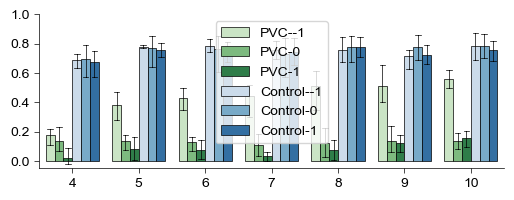

Bin 4:
  PVC: F_onewayResult(statistic=3.803501797531527, pvalue=0.06903698655863216)
  Control: F_onewayResult(statistic=0.026769180256614414, pvalue=0.9736727628050547)

Bin 5:
  PVC: F_onewayResult(statistic=12.37334540431377, pvalue=0.0035619701112965508)
  Control: F_onewayResult(statistic=0.05405024414970042, pvalue=0.947727446059345)

Bin 6:
  PVC: F_onewayResult(statistic=22.71324996225197, pvalue=0.0005027279757422254)
  Control: F_onewayResult(statistic=0.17001640307373134, pvalue=0.8466207570236755)

Bin 7:
  PVC: F_onewayResult(statistic=20.890689277709082, pvalue=0.0006669484567081974)
  Control: F_onewayResult(statistic=0.04128700275425789, pvalue=0.9597567801395289)

Bin 8:
  PVC: F_onewayResult(statistic=14.492662334049676, pvalue=0.0021889820801890268)
  Control: F_onewayResult(statistic=0.046598096714670884, pvalue=0.9547280307602898)

Bin 9:
  PVC: F_onewayResult(statistic=14.974659299916652, pvalue=0.0019748950383747937)
  Control: F_onewayResult(statistic=0.5951780

In [3]:
def get_pvc(mouse: int, session: int):
    file_idx = np.where(f2['MiceID'] == mouse)[0][session]
    
    with open(f2['Trace File'][file_idx], 'rb') as handle:
        trace = pickle.load(handle)

    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)

    bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[6]])-1
    
    averaged_map0 = np.mean(np.stack([
        trace[f'node {i}']['smooth_map_all'] for i in [0, 4, 5, 9]
    ], axis=2), axis=2)

    averaged_map6 = trace[f'node 8']['smooth_map_all']
    averaged_map1 = trace[f'node 1']['smooth_map_all']

    pvc_corr = np.zeros(7)
    pvc_ctrl = np.zeros(7)
    for i in range(4, 11):
        b = np.asarray(Father2SonGraph[CP_DSP[6][i]])
        pvc_corr[i-4] = np.corrcoef(averaged_map0[:, b-1].flatten(), averaged_map6[:, b-1].flatten())[0, 1]
        pvc_ctrl[i-4] = np.corrcoef(averaged_map0[:, b-1].flatten(), averaged_map1[:, b-1].flatten())[0, 1]

    return pvc_corr, np.arange(4, 11), pvc_ctrl

if exists(join(figdata, f"{code_id} [PVC on Pre-Final Segment].pkl")) == False:
    CorrPFS = {
        'MiceID': [],
        'Session': [],
        'Bin': [],
        'PVC': [],
        'Type': []
    }
    
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for s in tqdm(range(7)):
            pvc_corr, bins, pvc_ctrl = get_pvc(mouse, s)
            CorrPFS['MiceID'].append(np.repeat(mouse, len(pvc_corr)*2))
            CorrPFS['Session'].append(np.repeat(session_convertor[mouse][s], len(pvc_corr)*2))
            CorrPFS['Bin'].append(np.concatenate([bins, bins]))
            CorrPFS['PVC'].append(np.concatenate([pvc_corr, pvc_ctrl]))
            CorrPFS['Type'].append(np.concatenate([np.repeat('PVC', len(pvc_corr)), np.repeat('Control', len(pvc_ctrl))]))
    
    for k in CorrPFS.keys():
        CorrPFS[k] = np.concatenate(CorrPFS[k])
        
    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment].pkl"), 'wb') as f:
        pickle.dump(CorrPFS, f)
        
    CorrPFSD = pd.DataFrame(CorrPFS)
    CorrPFSD.to_excel(join(figdata, f"{code_id} [PVC on Pre-Final Segment].xlsx"), index=False)
    print(len(CorrPFSD))
else:
    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment].pkl"), 'rb') as f:
        CorrPFSD = pickle.load(f)

fig = plt.figure(figsize=(6, 2))
SubData = SubDict(CorrPFSD, CorrPFSD.keys(), np.where((np.abs(CorrPFSD['Session']) <= 1))[0])
SubData['hue'] = np.array([f"{SubData['Type'][i]}-{SubData['Session'][i]}" for i in range(len(SubData['Type']))])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.barplot(
    x=SubData['Bin'], 
    y=SubData['PVC'], 
    hue=SubData['hue'], 
    hue_order=['PVC--1', 'PVC-0', 'PVC-1', 'Control--1', 'Control-0', 'Control-1'],
    ax=ax, 
    palette=sns.color_palette("Greens", 3) + sns.color_palette("Blues", 3),
    capsize=0.5,
    edgecolor='black',
    linewidth=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'}
)
ax.set_ylim(-0.05, 1)
ax.set_yticks(np.linspace(0, 1, 6))
plt.savefig(join(loc, "PVC on Pre-Final Segment.png"), dpi=600)
plt.savefig(join(loc, "PVC on Pre-Final Segment.svg"), dpi=600)
plt.show()

for b in range(4, 11):
    SubData = SubDict(CorrPFSD, CorrPFSD.keys(), np.where((CorrPFSD['Bin'] == b))[0])
    x0 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'PVC')&(SubData['Session'] == -1))[0])
    x1 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'PVC')&(SubData['Session'] == 0))[0])
    x2 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'PVC')&(SubData['Session'] == 1))[0])
    x3 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'Control')&(SubData['Session'] == -1))[0])
    x4 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'Control')&(SubData['Session'] == 0))[0])
    x5 = SubDict(SubData, SubData.keys(), np.where((SubData['Type'] == 'Control')&(SubData['Session'] == 1))[0])
    
    print(f"Bin {b}:")
    print(f"  PVC: {f_oneway(x0['PVC'], x1['PVC'], x2['PVC'])}")
    print(f"  Control: {f_oneway(x3['PVC'], x4['PVC'], x5['PVC'])}", end='\n\n')

# Cross-Day Correlation

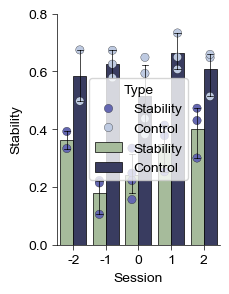

Control: F_onewayResult(statistic=1.1989121815206487, pvalue=0.36960286501514017)
Stability: F_onewayResult(statistic=4.489137633412617, pvalue=0.02466152655037741)
  Mean: 0.18048366246786948, STD: 0.05338563907755823, Max: 0.2222970765511138, Min: 0.105136451280838, Median: 0.21401745957165655, df: 2
  Mean: 0.4010416130611268, STD: 0.07339253423418224, Max: 0.47274276103067636, Min: 0.3001994614923298, Median: 0.4301826166603744, df: 2


In [3]:
if exists(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].pkl")) == False:
    CorrPFSStab = {
        'MiceID': [],
        'Session': [],
        'Stability': [],
        'Type': []
    }
    
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[6][4:11]]) - 1

    for mouse in [10212, 10224, 10227, 10232]:
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :]
        
        is_cell = np.where(index_map == 0, 0, 1)
        cell_count = np.sum(is_cell, axis=0)
        cell_idx = np.where(cell_count == 7)[0]
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        for s in tqdm(range(6)):
            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace1 = pickle.load(f)
                
            with open(f2['Trace File'][file_idx[s+1]], 'rb') as f:
                trace2 = pickle.load(f)
            
            averaged_map6_1 = trace1[f'node 8']['smooth_map_all']
            averaged_map6_2 = trace2[f'node 8']['smooth_map_all']
            
            averaged_map1_1 = trace1[f'node 1']['smooth_map_all']
            averaged_map1_2 = trace2[f'node 1']['smooth_map_all']
            
            corr = np.corrcoef(
                averaged_map6_1[np.ix_(index_map[s, cell_idx]-1, bins)].flatten(), 
                averaged_map6_2[np.ix_(index_map[s+1, cell_idx]-1, bins)].flatten()
            )[0, 1]

            corr_ctrl = np.corrcoef(
                averaged_map1_1[np.ix_(index_map[s, cell_idx]-1, bins)].flatten(), 
                averaged_map1_2[np.ix_(index_map[s+1, cell_idx]-1, bins)].flatten()
            )[0, 1]

            CorrPFSStab['MiceID'].append(np.repeat(mouse, 2))
            CorrPFSStab['Session'].append(np.repeat(session_convertor[mouse][s], 2))
            CorrPFSStab['Stability'].append(np.array([corr, corr_ctrl]))
            CorrPFSStab['Type'].append(np.array(['Stability', 'Control']))

    for k in CorrPFSStab.keys():
        CorrPFSStab[k] = np.concatenate(CorrPFSStab[k])

    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].pkl"), 'wb') as f:
        pickle.dump(CorrPFSStab, f)

    CorrPFSStabD = pd.DataFrame(CorrPFSStab)
    CorrPFSStabD.to_excel(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].xlsx"), index=False)
    print(len(CorrPFSStabD))
else:
    with open(join(figdata, f"{code_id} [PVC on Pre-Final Segment, Cross-Day].pkl"), 'rb') as f:
        CorrPFSStab = pickle.load(f)
        
fig = plt.figure(figsize=(2.1, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(CorrPFSStab, CorrPFSStab.keys(), np.where((np.abs(CorrPFSStab['Session']) <= 2))[0])
sns.stripplot(
    x = 'Session',
    y = 'Stability',
    data=SubData,
    hue='Type',
    palette = ['#6467b1', '#becae1'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0,
    edgecolor='k',
    ax = ax,
    zorder=2
)
sns.barplot(
    x = 'Session',
    y = 'Stability',
    data=SubData,
    hue='Type',
    palette = [RemappingPalette[1], RemappingPalette[0]],
    capsize=0.4,
    edgecolor='k',
    linewidth=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    ax = ax,
    zorder=1
)
ax.set_ylim(0, 0.8)
ax.set_yticks(np.linspace(0, 0.8, 5))
plt.savefig(join(loc, "PVC on Pre-Final Segment, Cross-Day.png"), dpi=600)
plt.savefig(join(loc, "PVC on Pre-Final Segment, Cross-Day.svg"), dpi=600)
plt.show()

res = [SubData['Stability'][(SubData['Session'] == s)&(SubData['Type'] == 'Stability')] for s in [-2, -1, 0, 1, 2]]
res0 = [SubData['Stability'][(SubData['Session'] == s)&(SubData['Type'] == 'Control')] for s in [-2, -1, 0, 1, 2]]
print(f"Control: {f_oneway(*res0)}")
print(f"Stability: {f_oneway(*res)}")
print_estimator(res[1])
print_estimator(res[4])

# Cross-day Correlation on Initial Segment

Bin 1: F_onewayResult(statistic=1.283436027357422, pvalue=0.34354759192103157)
Bin 2: F_onewayResult(statistic=0.9314236555264428, pvalue=0.44433878652857767)
Bin 3: F_onewayResult(statistic=0.5495202021391097, pvalue=0.6037467517982684)


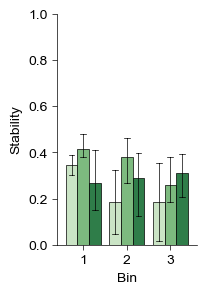

C:\Users\12454\AppData\Local\Temp\ipykernel_4668\1077895742.py:135: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


Bin 1: 0.04594529793708406
Bin 2: 0.4357345939154793
Bin 3: 0.1976399658137324


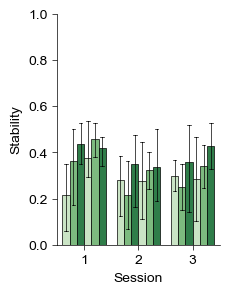

In [51]:
if exists(join(figdata, f"{code_id} [PVC on Initial Segment, Cross-Day].pkl")) == False:
    CorrIS = {
        'MiceID': [],
        'Session': [],
        'Session2': [],
        'Stability': [],
        'Bin': []
    }
    
    session_convertor = {
        10212: np.arange(-5, 2),
        10224: np.arange(7),
        10227: np.arange(-3, 4),
        10232: np.arange(-1, 6)
    }
    bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[6][1:4]]) - 1
    
    for mouse in [10212, 10224, 10227, 10232]:
        with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as f:
            index_map = pickle.load(f).astype(np.int64)
            
        if mouse != 10232:
            index_map = index_map[1:, :]
        
        is_cell = np.where(index_map == 0, 0, 1)
        cell_count = np.sum(is_cell, axis=0)
        cell_idx = np.where(cell_count == 7)[0]          
        file_idx = np.where(f2['MiceID'] == mouse)[0]
        
        for s in tqdm(range(6)):

            with open(f2['Trace File'][file_idx[s]], 'rb') as f:
                trace1 = pickle.load(f)
                
            with open(f2['Trace File'][file_idx[s+1]], 'rb') as f:
                trace2 = pickle.load(f)
                
          
            
            averaged_map6_1 = trace1[f'node 8']['smooth_map_all']
            averaged_map6_2 = trace2[f'node 8']['smooth_map_all']
            
            averaged_map1_1 = trace1[f'node 1']['smooth_map_all']
            averaged_map1_2 = trace2[f'node 1']['smooth_map_all']
            
            corr = np.zeros(3)
            for b in range(3):
                bins = np.asarray(Father2SonGraph[CP_DSP[6][b+1]])-1
                corr[b] = np.corrcoef(
                    averaged_map6_1[np.ix_(index_map[s, cell_idx]-1, bins)].flatten(), 
                    averaged_map6_2[np.ix_(index_map[s+1, cell_idx]-1, bins)].flatten()
                )[0, 1]

            CorrIS['MiceID'].append(np.repeat(mouse, 3))
            CorrIS['Bin'].append(np.arange(1, 4))
            CorrIS['Session'].append(np.repeat(session_convertor[mouse][s+1], 3))
            CorrIS['Session2'].append(np.repeat(s+1, 3))
            CorrIS['Stability'].append(corr)
    
    for k in CorrIS.keys():
        CorrIS[k] = np.concatenate(CorrIS[k])
          
    with open(join(figdata, f"{code_id} [PVC on Initial Segment, Cross-Day].pkl"), 'wb') as f:
        pickle.dump(CorrIS, f)
        
    CorrISD = pd.DataFrame(CorrIS)
    CorrISD.to_excel(join(figdata, f"{code_id} [PVC on Initial Segment, Cross-Day].xlsx"), index=False)
    print(len(CorrISD))
else:
    with open(join(figdata, f"{code_id} [PVC on Initial Segment, Cross-Day].pkl"), 'rb') as f:
        CorrIS = pickle.load(f)

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(CorrIS, CorrIS.keys(), np.where((np.abs(CorrIS['Session']) <= 1))[0])
"""
sns.stripplot(
    x = 'Bin',
    y = 'Stability',
    data=SubData,
    hue='Session',
    palette = 'Greens',
    size = 6,
    linewidth=0.2,
    jitter=0.1,
    edgecolor='k',
    legend=False,
    ax = ax,
    zorder=2
)
"""
sns.barplot(
    x = 'Bin',
    y = 'Stability',
    data=SubData,
    hue='Session',
    palette = sns.color_palette("Greens", 3),
    capsize=0.4,
    edgecolor='k',
    linewidth=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    ax = ax,
    zorder=1,
    legend=False    
)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel("Bin")
ax.set_xlim(-0.6, 2.6)
plt.savefig(join(loc, "PVC on Initial Segment, Cross-Day [StMT].png"), dpi=600)
plt.savefig(join(loc, "PVC on Initial Segment, Cross-Day [StMT].svg"), dpi=600)
for b in range(1, 4):
    res = [SubData['Stability'][(SubData['Session'] == s) & (SubData['Bin'] == b)] for s in [-1, 0, 1]]
    print(f"Bin {b}: {f_oneway(*res)}")
    
plt.show()

fig = plt.figure(figsize=(2.1, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
"""
sns.stripplot(
    x = 'Session2',
    y = 'Stability',
    data=CorrIS,
    hue='MiceID',
    palette = ['k']+MicePaletteDSP[1:],
    size = 6,
    linewidth=0.2,
    jitter=0.1,
    edgecolor='k',
    ax = ax,
    legend=False,
    zorder=2
)
"""
sns.barplot(
    x = 'Bin',
    y = 'Stability',
    data=CorrIS,
    hue='Session2',
    palette = sns.color_palette("Greens", 3),
    capsize=0.4,
    edgecolor='k',
    linewidth=0.5,
    err_kws={'linewidth': 0.5, 'color': 'k'},
    ax = ax,
    zorder=1,
    legend=False
)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xlabel("Session")
plt.savefig(join(loc, "PVC on Initial Segment, Cross-Day [Session].png"), dpi=600)
plt.savefig(join(loc, "PVC on Initial Segment, Cross-Day [Session].svg"), dpi=600)
for b in range(1, 4):
    res = CorrIS['Bin'] == b
    print(f"Bin {b}: {linregress(CorrIS['Session2'][res], CorrIS['Stability'][res]).pvalue}")
plt.show()